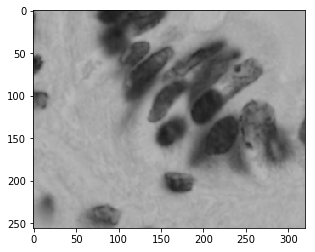

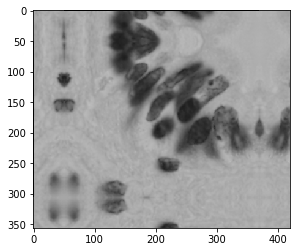

In [66]:
import utils.constants as const
import utils.pathbuilder as upb
import os
import string
import random
import csv
from PIL import Image
import numpy as np
import skimage.io
from skimage.color import rgba2rgb, rgb2gray, gray2rgb
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline
%run 'add_padding.ipynb'

In [3]:
FOLDER_NAME = './train-img/'
TRAIN_FOLDER = './train/'
VALIDATION_FOLDER = './validation/'
TEST_FOLDER = './test/'
PREVIEW_FOLDER = './preview/'
REDUCED_FOLDER = './reduced/'
IGNORED_FILES = ['.DS_Store']
TRAIN_DATA = './train_data.csv'

In [4]:
# Create a folder un current directory if not exists
def create_folder_if_not_exists(folder_name):
    if os.path.isdir(folder_name) == False:
        os.makedirs(folder_name)

In [5]:
def id_generator(size=10, chars=string.ascii_uppercase + string.digits):
    return ''.join(random.choice(chars) for _ in range(size))

In [6]:
id_generator()

'6M3IA2V96R'

In [7]:
create_folder_if_not_exists(TRAIN_FOLDER)
create_folder_if_not_exists(VALIDATION_FOLDER)
create_folder_if_not_exists(TEST_FOLDER)
create_folder_if_not_exists(PREVIEW_FOLDER)
create_folder_if_not_exists(REDUCED_FOLDER)

In [8]:
print('FINISH CREATION OF FOLDERS')

FINISH CREATION OF FOLDERS


(256, 256, 4)


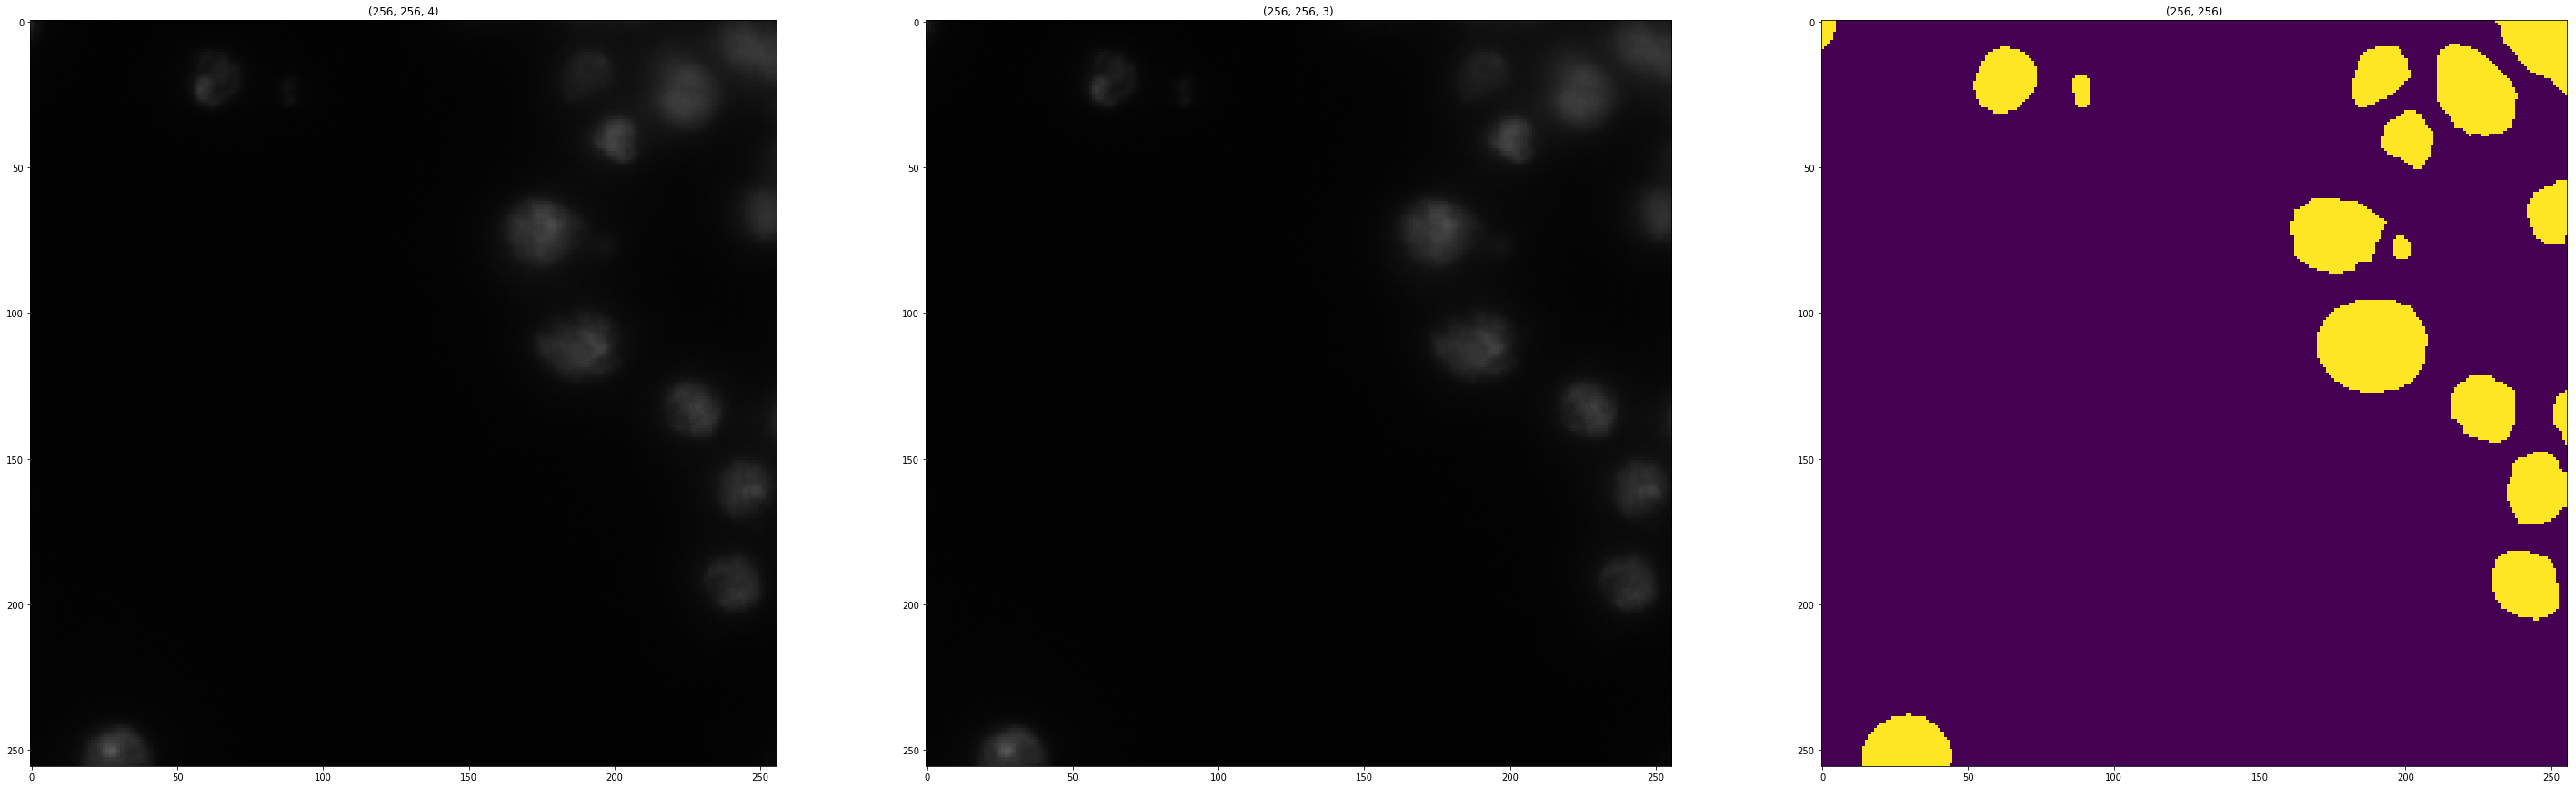

In [9]:
images_id = [x for x in os.listdir(const.STAGE1_TRAIN_PATH)]
plt.close('all')
fig, ax = plt.subplots(nrows=1,ncols=3, figsize=(50,50))
for image_id in images_id:
    if image_id in IGNORED_FILES:
        continue
    image_path = os.path.join(const.STAGE1_TRAIN_PATH, image_id, 'images', '{}.png'.format(image_id))
    mask_paths = os.path.join(const.STAGE1_TRAIN_PATH, image_id, 'masks', '*.png')

    image = skimage.io.imread(image_path)
    masks = skimage.io.imread_collection(mask_paths).concatenate()
    mask = np.zeros(image.shape[:2], np.uint16)
    
    for mask_idx in range(masks.shape[0]):
        mask[masks[mask_idx] > 0] = 1
    
    print(image.shape)
    ax[0].imshow(image)
    ax[0].set_title(image.shape)
    ax[1].imshow(rgba2rgb(image))
    ax[1].set_title(rgba2rgb(image).shape)
    ax[2].imshow(mask)
    ax[2].set_title(mask.shape)
    break

In [74]:
### Get samples

images_id = [x for x in os.listdir(const.STAGE1_TRAIN_PATH)]
image_id = images_id[5]

image_path = os.path.join(const.STAGE1_TRAIN_PATH, image_id, 'images', '{}.png'.format(image_id))
mask_paths = os.path.join(const.STAGE1_TRAIN_PATH, image_id, 'masks', '*.png')

image = gray2rgb(rgb2gray(skimage.io.imread(image_path)))
masks = skimage.io.imread_collection(mask_paths).concatenate()
mask = np.zeros(image.shape[:2], np.uint16)

for mask_idx in range(masks.shape[0]):
    mask[masks[mask_idx] > 0] = 1

image = np.uint8(image * 255)
if image.mean() > 255 / 2:
    image = 255 - image
    
print(image.shape)
print(mask.shape)


(360, 360, 3)
(360, 360)


(460, 460, 3)
(460, 460)


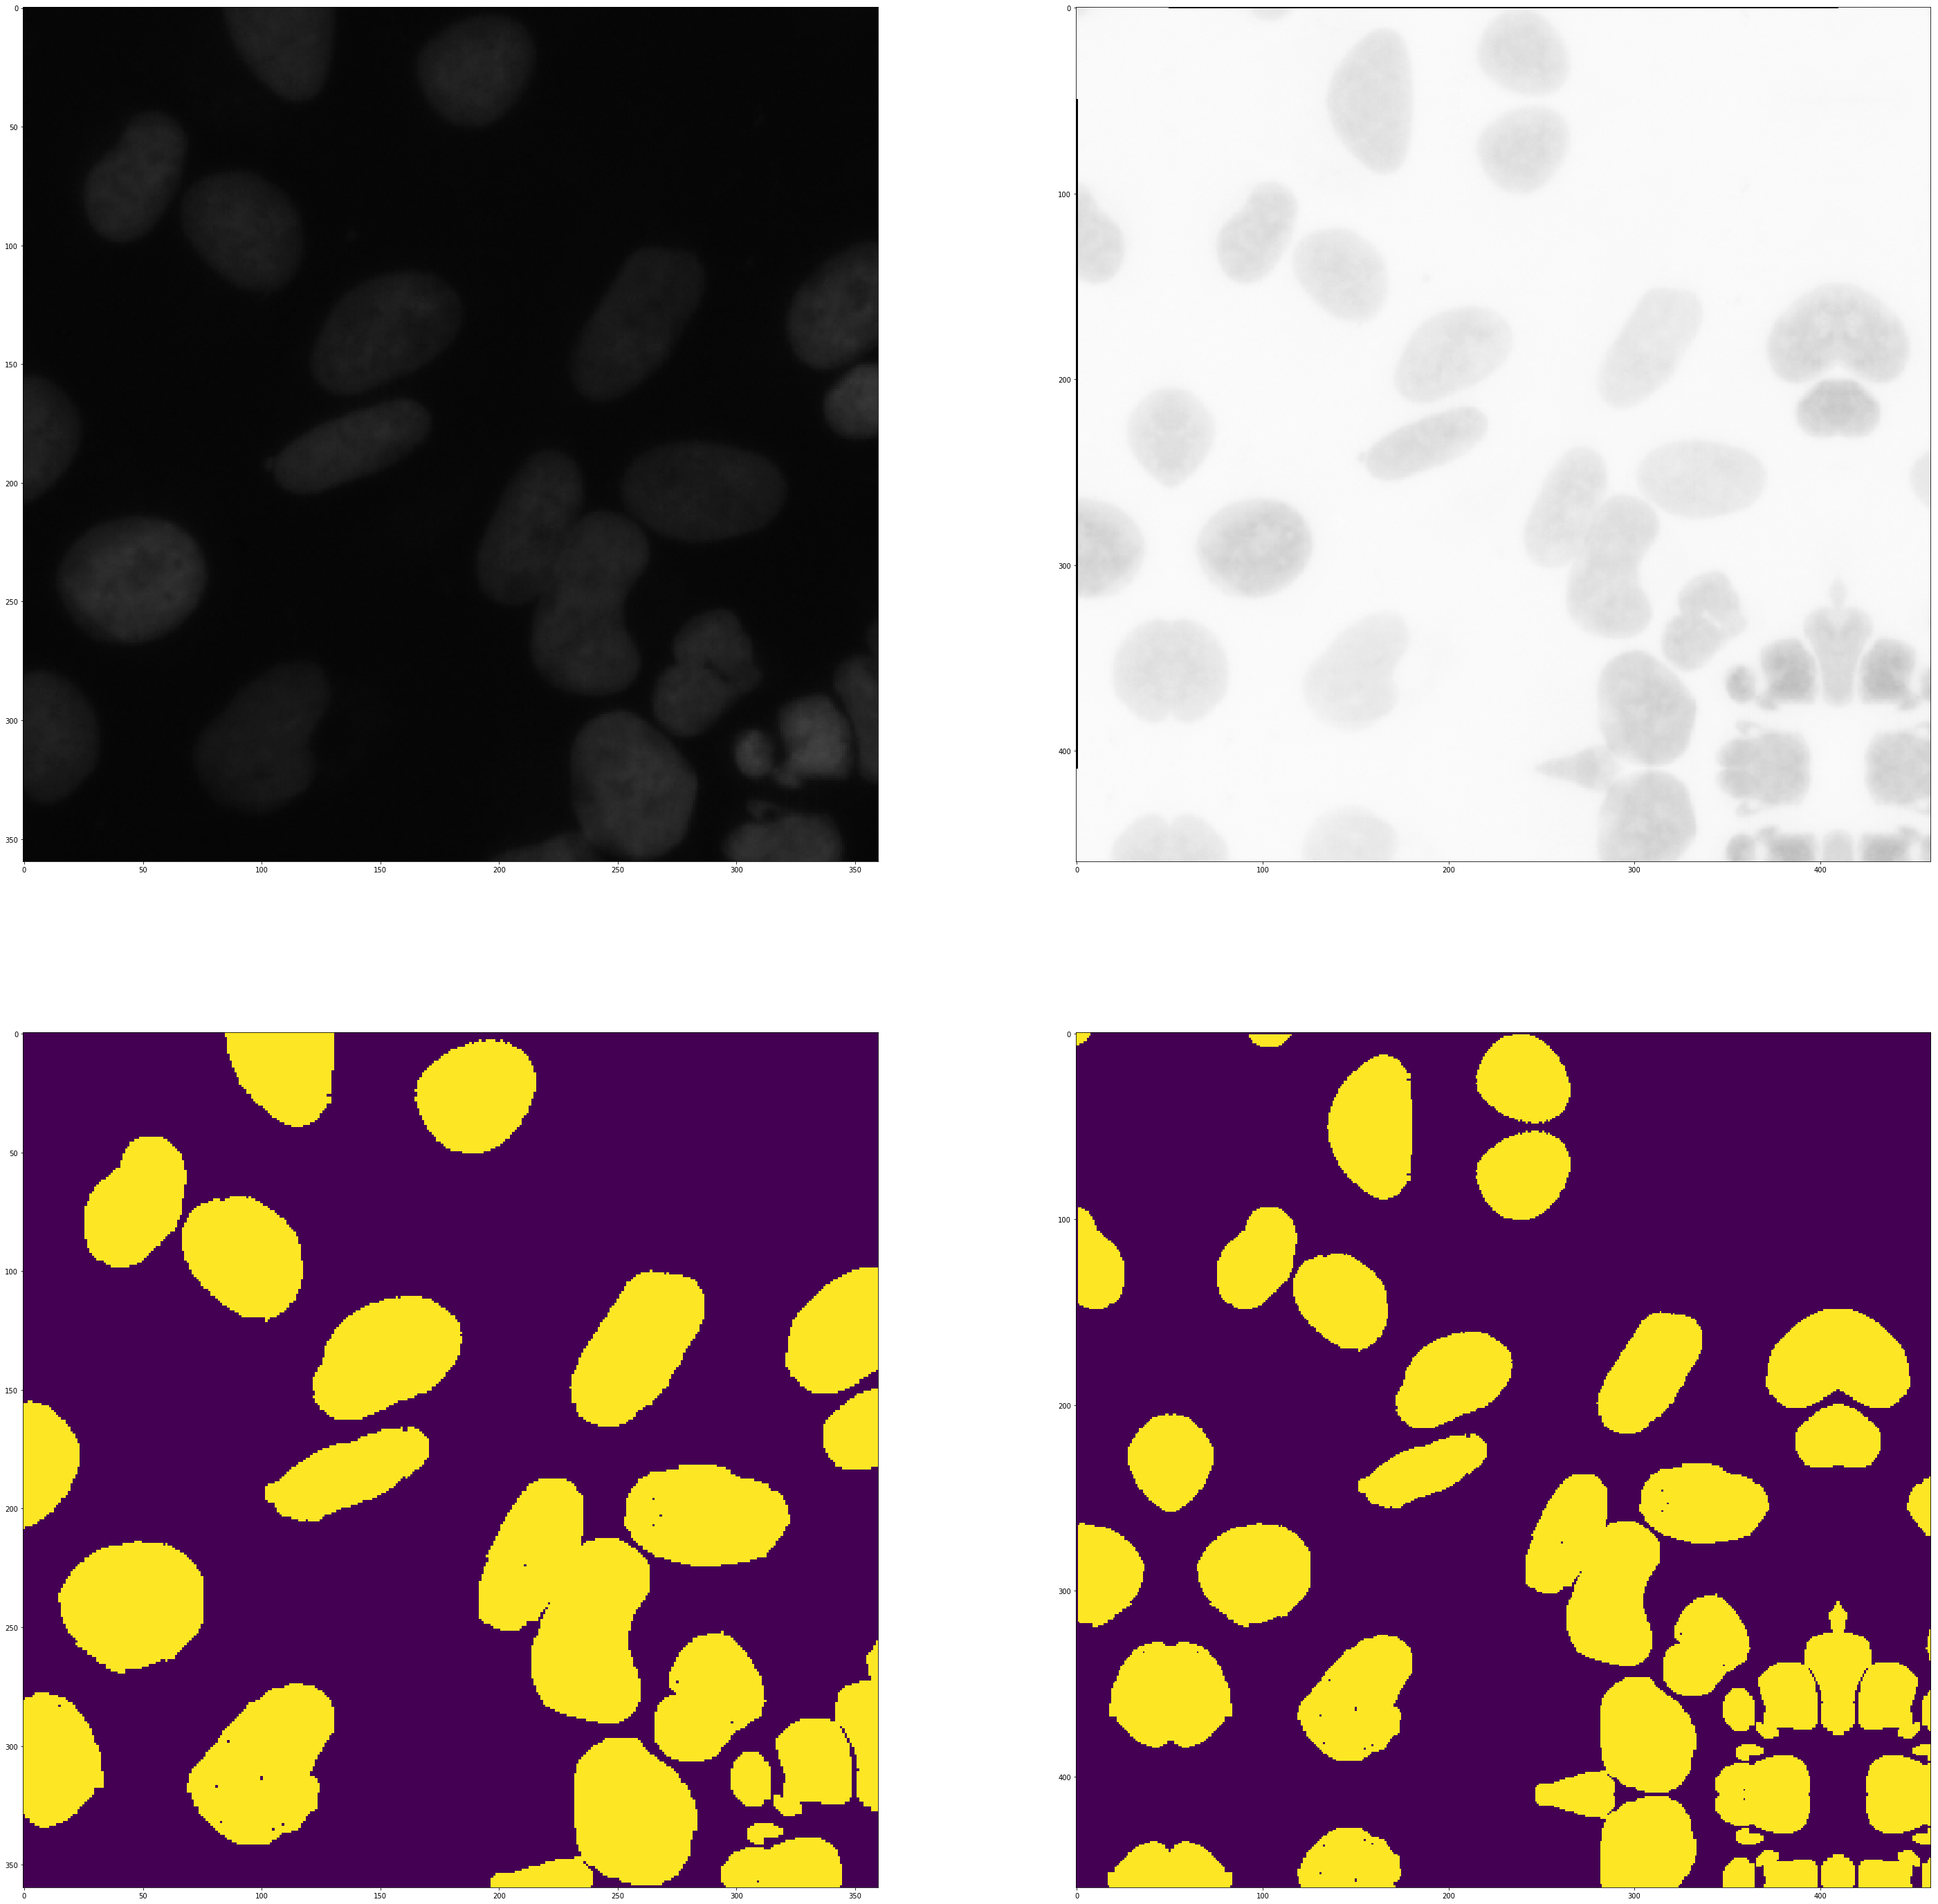

In [75]:
# Adding padding to image and mask
padd_image = apply_padding(image)
padd_mask = apply_padding(mask)
print(padd_image.shape)
print(padd_mask.shape)
plt.close('all')
fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(50,50))
ax[0][0].imshow(image)
ax[0][1].imshow(padd_image)
ax[1][0].imshow(mask)
ax[1][1].imshow(padd_mask)

In [68]:
# Generate randomly coordinates for sample
NUMBER_OF_SAMPLES = 9
padding = 47
cX = [] # position in X axis
cY = [] # position in Y axis
w, h, _ = image.shape
for i in range(NUMBER_OF_SAMPLES):
    cX.append(random.randint(1, w) + padding) # Fixed size for border padding
    cY.append(random.randint(1, h) + padding) # Fixed size for border padding

print(cX)
print(cY)

[252, 126, 67, 65, 206, 89, 139, 91, 137]
[205, 52, 129, 122, 209, 197, 197, 144, 250]


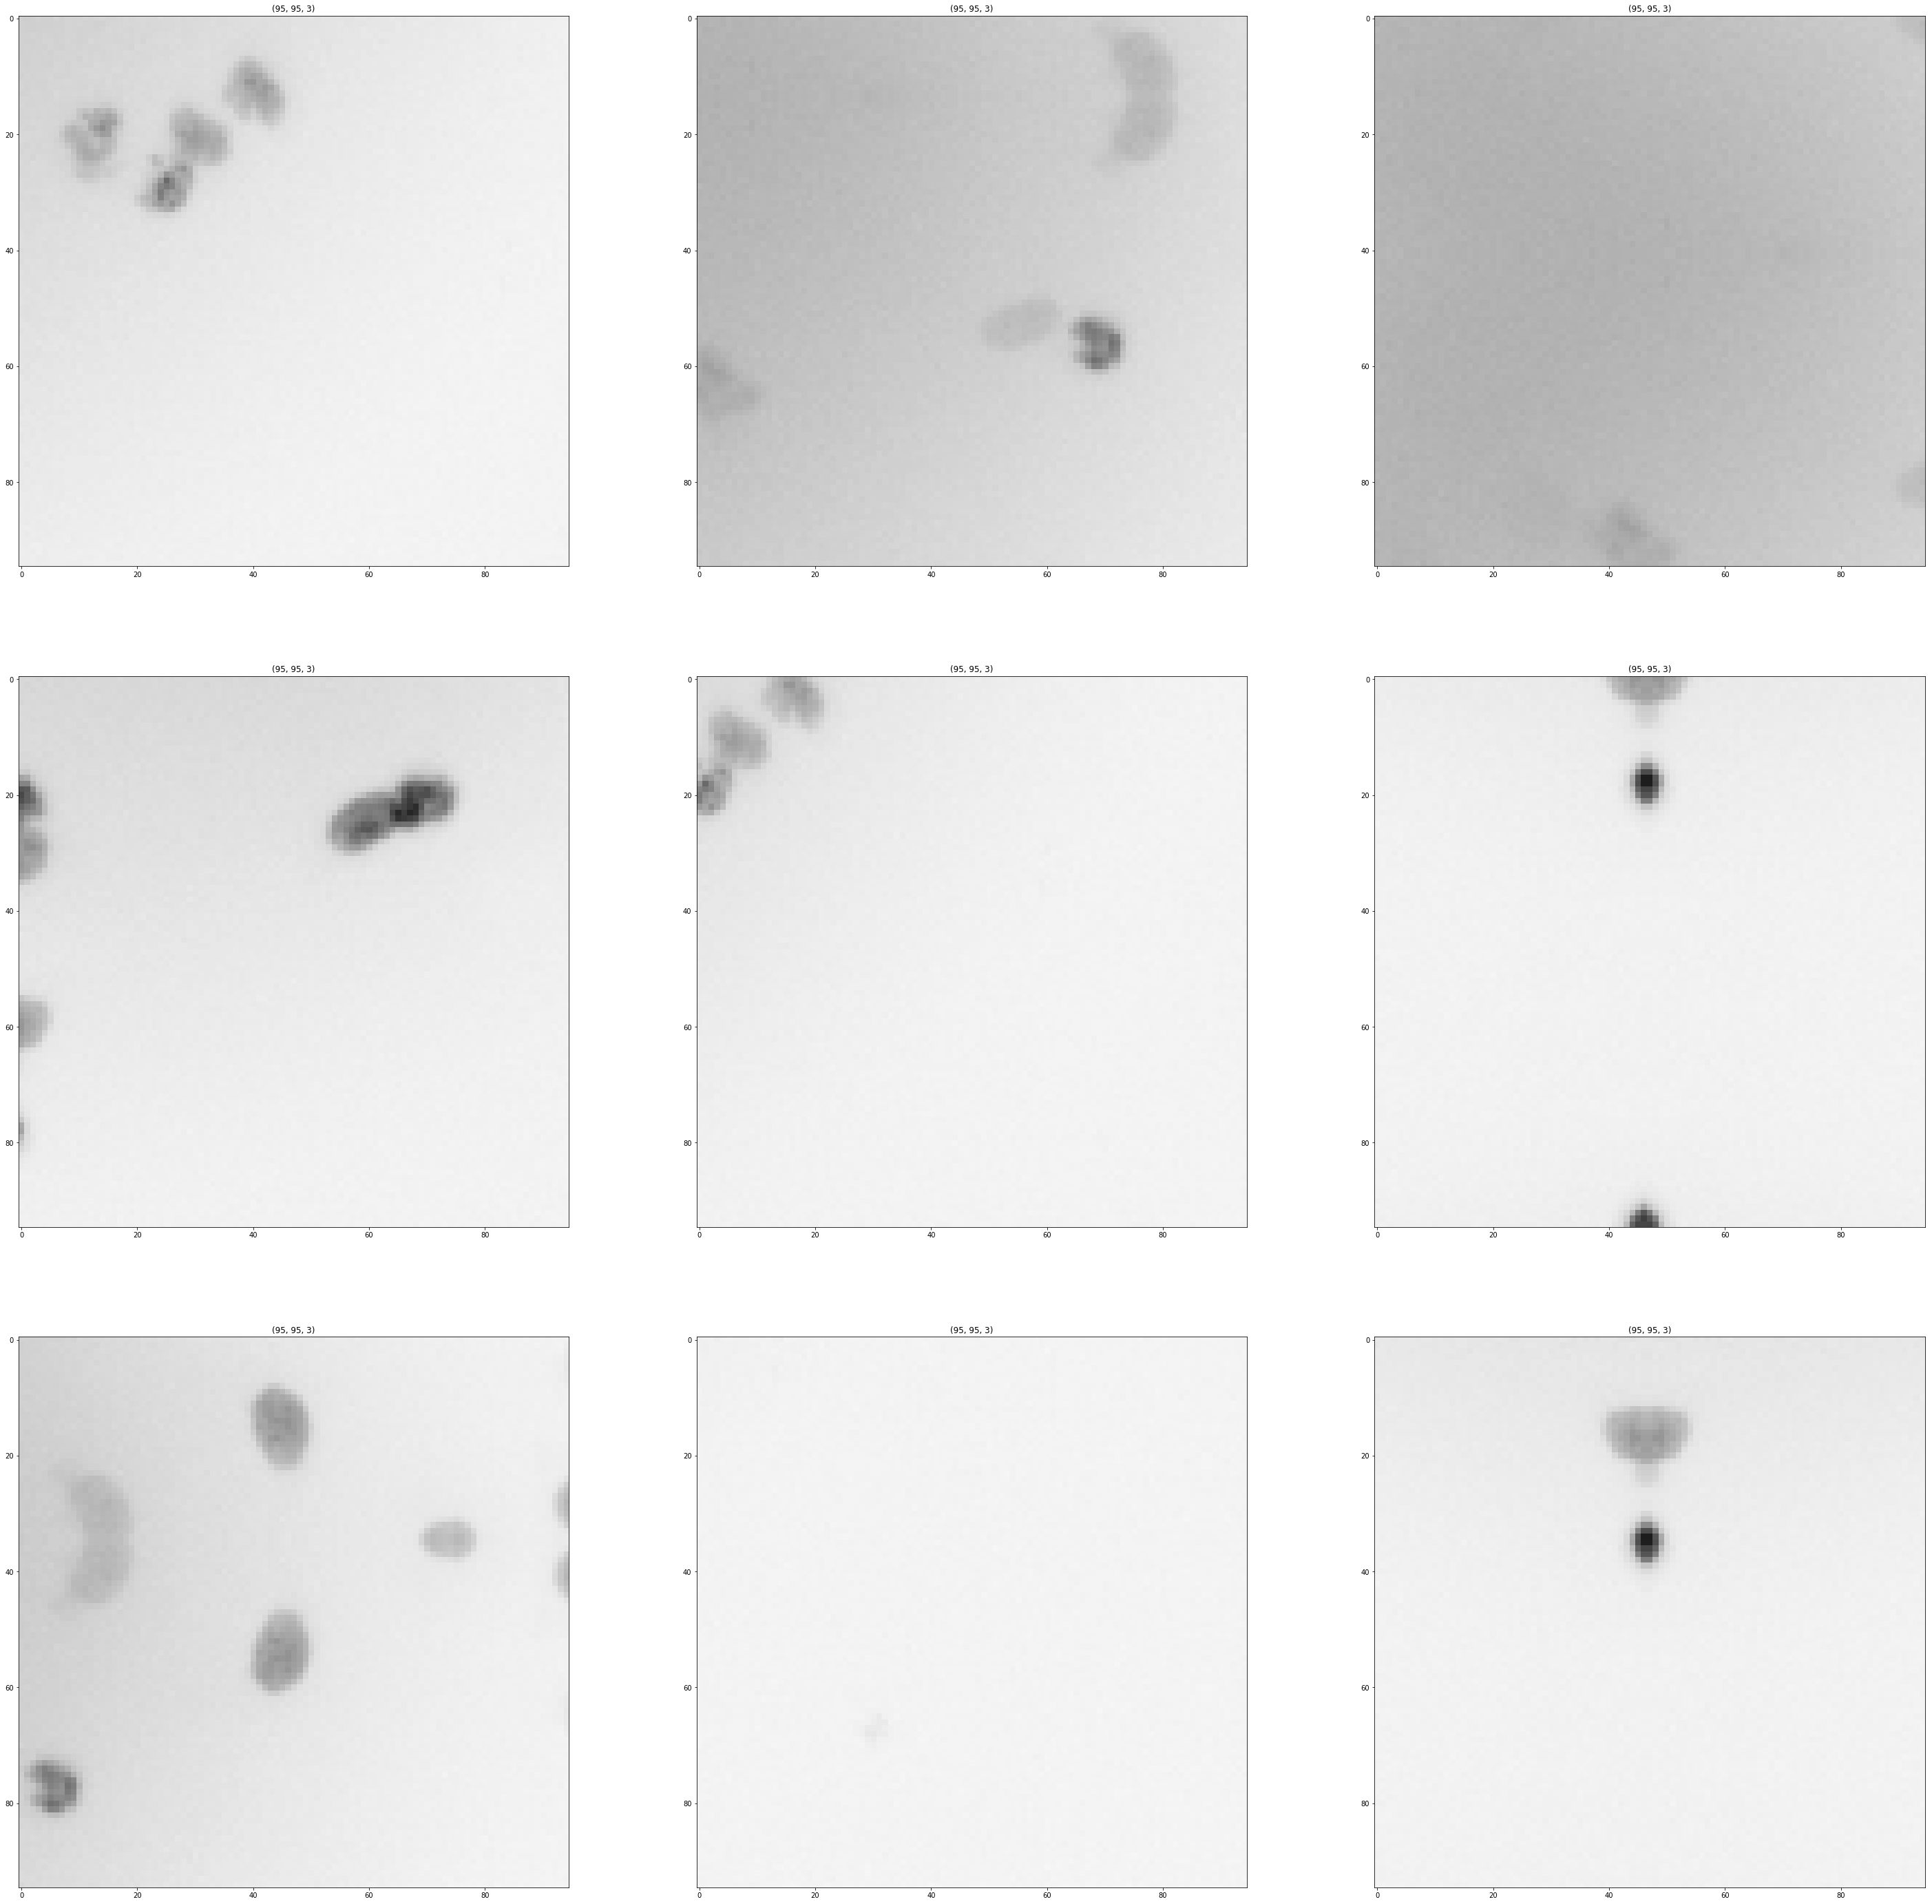

In [48]:
# Samples on Image
plt.close('all')
fig, ax = plt.subplots(nrows=3,ncols=3, figsize=(50,50))
for i in range(3):
    for j in range(3):
        x, y = cX[i * 3 + j], cY[i * 3 + j]
        sample = padd_image[x - padding: x + padding + 1,y - padding: y + padding + 1, :]
        ax[i][j].imshow(sample)
        ax[i][j].set_title(sample.shape)

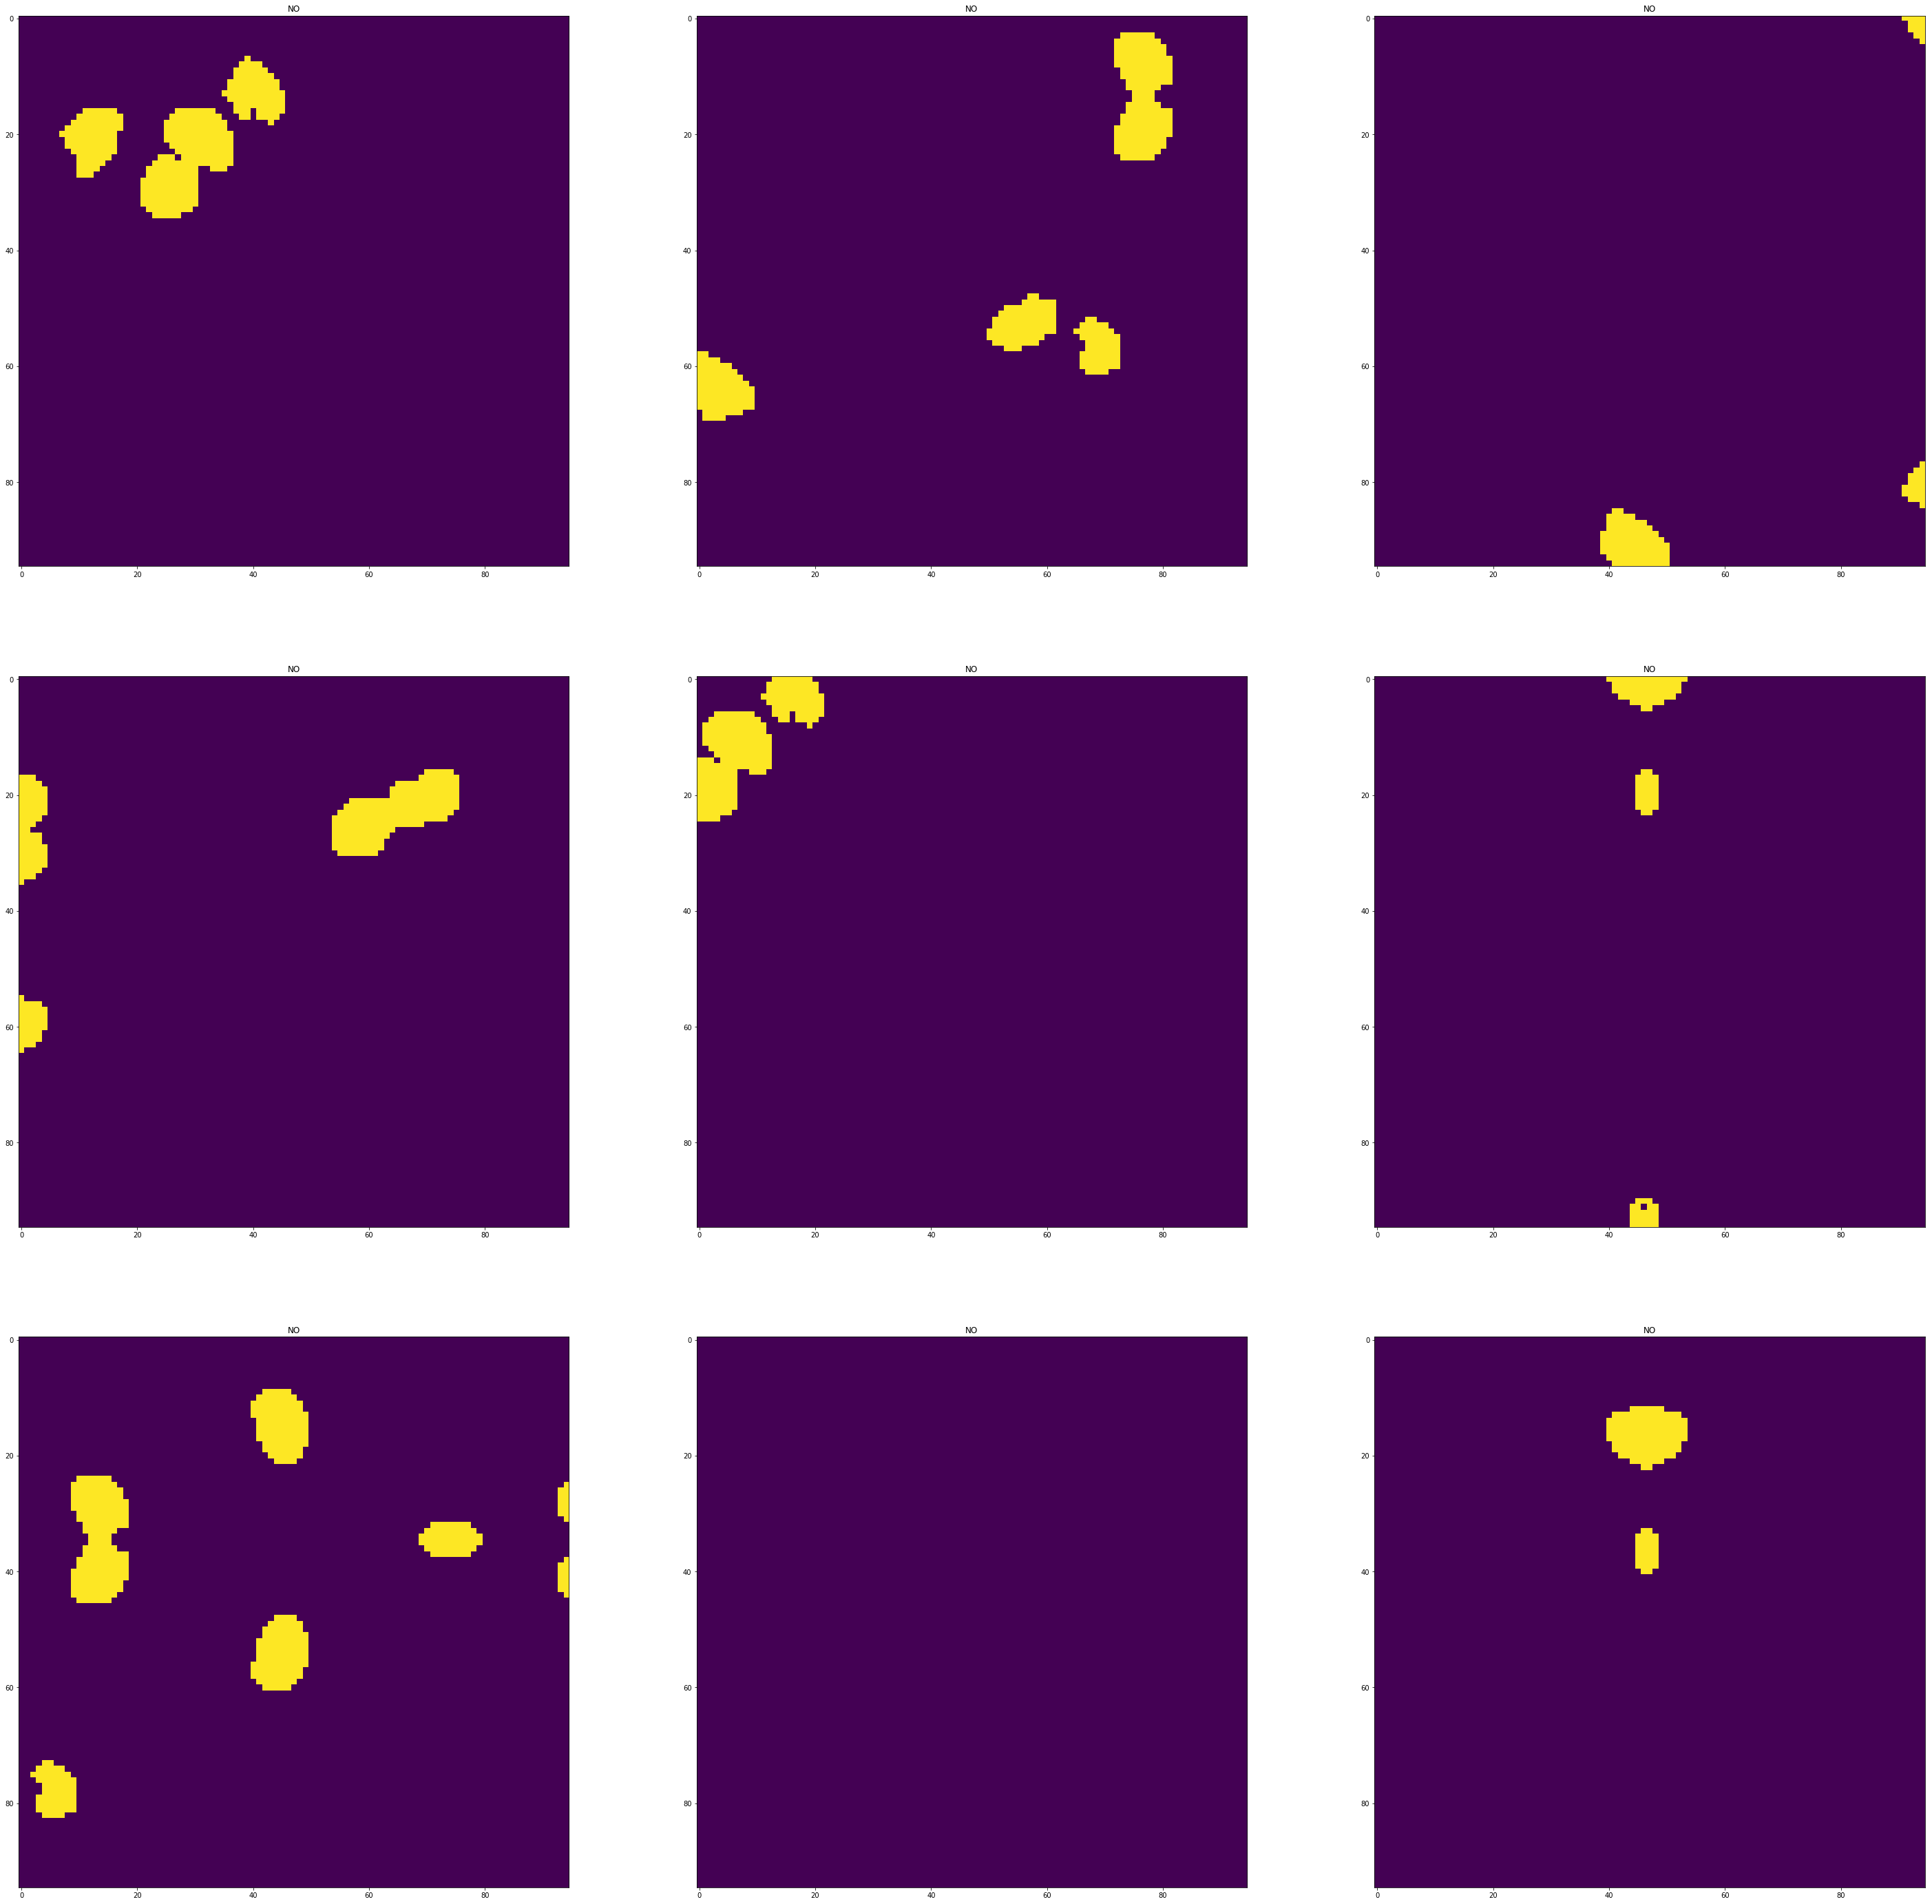

In [49]:
# Samples on mask
plt.close('all')
fig, ax = plt.subplots(nrows=3,ncols=3, figsize=(50,50))
for i in range(3):
    for j in range(3):
        x, y = cX[i * 3 + j], cY[i * 3 + j]
        sample = padd_mask[x - padding: x + padding + 1,y - padding : y + padding + 1]
        ax[i][j].imshow(sample)
        ax[i][j].set_title("YES" if padd_mask[x][y] == 1 else "NO")

In [77]:
# Counting the number of training examples in one image
print("Original image shape : ", image.shape)
print("Original mask shape  : ", mask.shape)
print("Padded image shape   : ", padd_image.shape)
print("Padded mask shape    : ", padd_mask.shape)
print("Padding: ", padding)
w, h, _ = image.shape
print("Total of pixel to analyze: ", w * h)
cont_positive_samples = 0
cont_negative_samples = 0
total_not_valid_samples = 0
negative_counted_samples = 0
for x in range(w):
    for y in range(h):
        sample = padd_mask[x - padding: x + padding + 1,y - padding : y + padding + 1]
        isValidForTraining = np.sum(sample) > 0
        if isValidForTraining:
            cont_positive_samples += (padd_mask[x][y] / 255. == 1)
            cont_negative_samples += (padd_mask[x][y] / 255. == 0)
            if (padd_mask[x][y] / 255. == 0):
                factor = random.randint(0, 100)
                if factor < 5:
                    negative_counted_samples += 1
        else:
            total_not_valid_samples += 1
            
total_valid_samples = cont_positive_samples + cont_negative_samples
rate_positive_negative = cont_positive_samples * 100. / cont_negative_samples
print("------------------------------------------------")
print("Total not valid samples : ", int(total_not_valid_samples))
print("Total valid samples     : ", int(total_valid_samples))
print("Total positivie samples : ", int(cont_positive_samples))
print("Total negative samples  : ", int(cont_negative_samples))
print("------------------------------------------------")
print("Sum of valid and not valid : ", int(total_valid_samples + total_not_valid_samples))
print("Positive / Negative: %.2f%%"%rate_positive_negative)
print("------------------------------------------------")
print("Negative counted samples : ", int(negative_counted_samples))
print("Percentage : %.2f%%"%(negative_counted_samples * 100. / cont_negative_samples))

positive_taken = 0
negative_taken = 0
for x in range(w):
    for y in range(h):
        sample = padd_mask[x - padding: x + padding + 1,y - padding : y + padding + 1]
        isValidForTraining = np.sum(sample) > 0
        if isValidForTraining:
            if (padd_mask[x][y] / 255. == 0):
                factor = random.randint(0, 1000)
                if factor < rate_positive_negative * 10:
                    negative_taken += 1
            else:
                positive_taken += 1

new_rate = positive_taken * 100. / negative_taken
print("------------------------------------------------")
print("Positive taken : ", positive_taken)
print("Negative taken : ", negative_taken)
print("Total taken    : ", positive_taken + negative_taken)
print("New rate       : %.2f%%"%new_rate)

Original image shape :  (360, 360, 3)
Original mask shape  :  (360, 360)
Padded image shape   :  (460, 460, 3)
Padded mask shape    :  (460, 460)
Padding:  47
Total of pixel to analyze:  129600
------------------------------------------------
Total not valid samples :  34258
Total valid samples     :  95342
Total positivie samples :  28344
Total negative samples  :  66998
------------------------------------------------
Sum of valid and not valid :  129600
Positive / Negative: 42.31%
------------------------------------------------
Negative counted samples :  3237
Percentage : 4.83%
------------------------------------------------
Positive taken :  28344
Negative taken :  28124
Total taken    :  56468
New rate       : 100.78%


In [ ]:
# We can see that negative samples are almost 10x the positives one
# So to avoid skewed classes, we take randomly 10% of the negative samples
# To mantain it in almost equal proportion
# Doing that, each image will give us ~4k training examples
# Having 670 images, We have aprox. 670 x 4k = 3350k training examples
# ~2.6M training examples
# 80% training (2,1M)
# 10% cross validation (260k)
# 10% test (260k)
# We are assuming all images have same resolution. However we know that is not true

In [ ]:
# From here is for generalize. 
# Still pending of work

In [62]:
images_id = [x for x in os.listdir(const.STAGE1_TRAIN_PATH)]

for image_id in images_id:
    if image_id in IGNORED_FILES:
        continue
    image_path = os.path.join(const.STAGE1_TRAIN_PATH, image_id, 'images', '{}.png'.format(image_id))
    mask_paths = os.path.join(const.STAGE1_TRAIN_PATH, image_id, 'masks', '*.png')

    image = gray2rgb(rgb2gray(skimage.io.imread(image_path)))
    masks = skimage.io.imread_collection(mask_paths).concatenate()
    mask = np.zeros(image.shape[:2], np.uint16)
    
    for mask_idx in range(masks.shape[0]):
        mask[masks[mask_idx] > 0] = mask_idx + 1
 
    image = np.uint8(image * 255)
    if image.mean() > 255 / 2:
        image = 255 - image
        
    _image = Image.fromarray(image)
    _image.save(os.path.join(PREVIEW_FOLDER,'{}.png'.format(image_id)))
                    
    _mask = Image.fromarray(np.uint8(mask * 255))
    _mask.save(os.path.join(PREVIEW_FOLDER,'{}_mask.png'.format(image_id)))

print("FINISHED")

FINISHED


In [ ]:
train_data = open(TRAIN_DATA, 'w')
csvwriter = csv.writer(train_data)
dict_train = []
padding = 95
print_header = True

for image_id in images_id:
    if image_id in IGNORED_FILES:
        continue
        
    image_path = os.path.join(PREVIEW_FOLDER, '{}.png'.format(image_id))
    mask_path = os.path.join(PREVIEW_FOLDER, '{}_mask.png'.format(image_id))
    
    image = skimage.io.imread(image_path) / 255.
    mask = skimage.io.imread(mask_path) / 255.

    image = np.uint8(image * 255)
    mask = np.uint8(mask * 255)

    w, h, _ = image.shape
    for i in range(w - padding):
        for j in range(h - padding):
            
            sample = image[i: i + padding,j: j + padding, :]
            img = Image.fromarray(sample)
            
            filename = id_generator()
            img.save(os.path.join(REDUCED_FOLDER, filename + '.png'))
            
            isNuclei = mask[int(i + padding / 2)][int(j + padding / 2)]
            data = {
                'id': filename,
                'nuclei': isNuclei
            }
            
            if print_header:
                csvwriter.writerow(data.keys())
                print_header = False
            csvwriter.writerow(data.values())

train_data.close()
print("FINISHED")

In [ ]:
def __main__():
    print("Starting process")
    create_folder_if_not_exists(TRAIN_FOLDER)
    create_folder_if_not_exists(VALIDATION_FOLDER)
    create_folder_if_not_exists(TEST_FOLDER)
    print("TRAIN/VALIDATION/TEST folders created correctly")
    
    